In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds 

/home/ait_guest/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

2022-04-12 10:23:35.805791: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  50%|█████     | 1/2 [00:14<00:09,  9.78s/ url]

Dl Completed...: 100%|██████████| 2/2 [03:13<00:00, 111.88s/ url]

Dl Completed...: 100%|██████████| 2/2 [03:21<00:00, 100.58s/ url]


Dataset oxford_iiit_pet downloaded and prepared to /home/ait_guest/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


2022-04-12 10:27:14.400822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 10:27:15.110274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 10:27:15.110653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 10:27:15.127946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 10:27:15.128420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [4]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask-=1
    return input_image, input_mask

In [5]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"],(128,128))
    input_mask = tf.image.resize(datapoint["segmentation_mask"],(128,128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH

In [7]:
train_images = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset["test"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augmented_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augmented_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    
    def call(self, inputs, labels):
        inputs = self.augmented_inputs(inputs)
        labels = self.augmented_labels(labels)
        return inputs, labels

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

In [10]:
def display(display_list):
    plt.figure(figsize=(15,15))

    title=["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


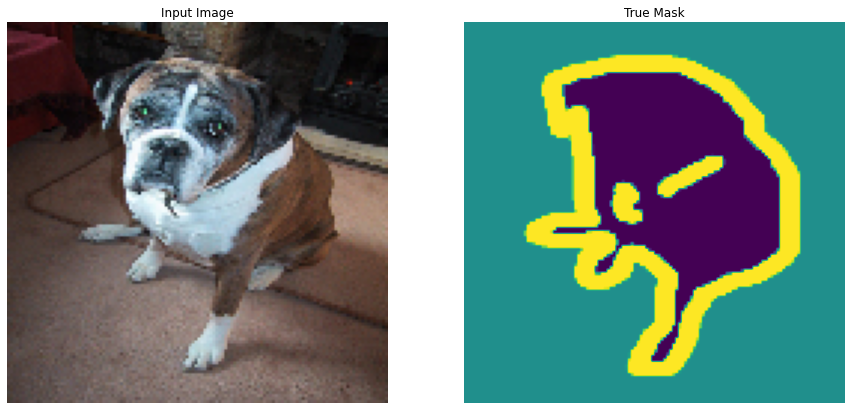

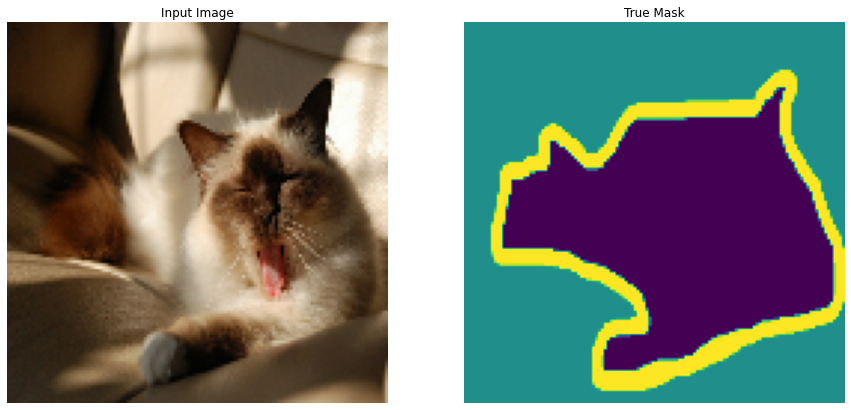

2022-04-12 10:43:34.368265: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [11]:
for images, mask in train_batches.take(2):
    sample_image, sample_mask = images[0], mask[0]
    display([sample_image,sample_mask])

Define Model

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)

layer_names = [
    "block_1_expand_relu",
    "block_3_expand_relu",
    "block_6_expand_relu",
    "block_13_expand_relu",
    "block_16_project"
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9420800/9406464 [==============================] - 3s 0us/step


In [13]:
up_stack = [
    pix2pix.upsample(512,3),
    pix2pix.upsample(256,3),
    pix2pix.upsample(128,3),
    pix2pix.upsample(64,3),
]

In [14]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128,128,3])

    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack,skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x,skip])
    
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding="same"
    )

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)